# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [1]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain
from argparse import Namespace

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from annoy import AnnoyIndex

In [2]:
DATA_PATH = Path('../data')
MODELS_PATH = Path('../models')

In [3]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        filtered_token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) 
                             in enumerate(filtered_token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
    
    def _create_sliding_window(self, window_size):
        tokens_size = len(self.tokens)

        for i in range(0, tokens_size):
#             center_word = islice(self.vectorized_tokens, i, i + 1)
#             left_context = islice(self.vectorized_tokens, i + 1, 
#                                   min(tokens_size, i + window_size + 1))
#             right_context = islice(self.vectorized_tokens, 
#                                    max(0, i - window_size), i)
#             yield from product(center_word, chain(left_context, right_context))
            center_word = self.vectorized_tokens[i:i+1]
#             context = []
#             context.extend(self.vectorized_tokens[max(0, i - window_size): i])
#             context.extend(self.vectorized_tokens[i + 1: min(tokens_size, i + window_size + 1)])
            left_context = self.vectorized_tokens[max(0, i - window_size): i]
            right_context = self.vectorized_tokens[i + 1: min(tokens_size, i + window_size + 1)]
            yield from product(center_word, chain(left_context, right_context))
        
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
        
    def generate_batches(self, window_size=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size)
        batch = list(zip(*islice(window, batch_size)))
        x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

        if drop_last:
            while batch and len(batch[0]) == batch_size:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
        else:
            while batch:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

In [261]:
class NaiveWord2VecClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super().__init__()
        
#         self.embedding = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
#                                       embedding_dim=embedding_size), dim=1)
# #                                       max_norm=1.0)
# #                                       scale_grad_by_freq=True)
                                      
#         self.fc1 = nn.utils.weight_norm(nn.Linear(in_features=embedding_size,
#                              out_features=vocabulary_size,
#                              bias=False), dim=1)

        self.embedding = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
                                              embedding_dim=embedding_size), dim=0)

        self.fc1 = nn.utils.weight_norm(nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size,
                             bias=False), dim=0)
        
    def forward(self, x_in):
#         self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=1)
#         self.fc1.weight.data = F.normalize(self.fc1.weight.data, p=2, dim=1)
        x_embedded = self.embedding(x_in)
        y_out = self.fc1(x_embedded)
        
        return y_out

In [262]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [263]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    model_state_path = MODELS_PATH/'naive_word2vec_embeddings.pth',
    weights_path = MODELS_PATH/'weights.npz',
    
    embedding_size = 100,
    
    seed = 42,
    cutoff = 10, # 10
    window_size = 1, # 1
    batch_size = 1024, #  1024
    learning_rate = 0.03, # 0.03
    iterations = 1000,
    save_iterations = 100,
    early_stopping_criteria = 1e8,
    factor=0.7, # 0.7
    patience=1000, # 1000
    
    cuda=True
)

In [264]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': [], # args.learning_rate
            'batch_idx': 0,
            'loss': [],
            'model_file_name': args.model_state_path}

def update_train_state(args, model, train_state):
    if train_state['batch_idx'] == 0:
        train_state['stop_early'] = False
        torch.save(model.state_dict(), train_state['model_file_name'])
    else:
        loss = train_state['loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
            train_state['early_stopping_step'] = 0
            
            if train_state['batch_idx'] % args.save_iterations == 0:
                torch.save(model.state_dict(), train_state['model_file_name'])
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

In [265]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: True


In [266]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=args.cutoff)

vocabulary_size = len(sg_batcher.vocab)
vocabulary_size

47134

In [267]:
set_seeds(args.seed)

classifier = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                                     embedding_size=args.embedding_size)
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(params=classifier.parameters(),
                      lr=args.learning_rate)

epoch_size = 2 * (args.window_size * len(sg_batcher.tokens) 
                  - np.math.factorial(args.window_size)) // args.batch_size

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=args.factor,
                                                 patience=args.patience)

train_bar = tqdm_notebook(desc='Training',
                          position=1,
#                           total=args.iterations,
                          total=epoch_size)

batch_generator = sg_batcher.generate_batches(window_size=args.window_size, 
                                              batch_size=args.batch_size)

train_state = make_train_state(args)

writer = SummaryWriter(log_dir='logs/task_3', comment='embedding_training')

running_loss = 0.
classifier.train()

try:
    for batch_idx, (x_batch, labels_batch) in enumerate(batch_generator, 1):
        x_batch = x_batch.to(args.device)
        labels_batch = labels_batch.to(args.device)

        optimizer.zero_grad()

        y_pred = classifier(x_in=x_batch)

        loss = loss_func(y_pred, labels_batch)
        loss_value = loss.item()
        running_loss += (loss_value - running_loss) / (batch_idx)
        loss.backward()
        
        learning_rate = optimizer.param_groups[0]['lr']
        
        train_state['batch_idx'] = batch_idx
        train_state['loss'].append(running_loss)
        train_state['learning_rate'].append(learning_rate)
#         writer.add_scalar('loss', scalar_value=loss, global_step=batch_idx)


        train_state = update_train_state(args=args,
                                         model=classifier,
                                         train_state=train_state)

        train_params = dict(loss=running_loss,
                            lr=learning_rate,
                            early_step=train_state['early_stopping_step'],
                            early_best=train_state['early_stopping_best_val'])
        train_bar.set_postfix(train_params)
        train_bar.update()
        
        optimizer.step()
        
        scheduler.step(train_state['loss'][-1])

        if train_state['stop_early'] or (batch_idx == epoch_size):
            torch.save(model.state_dict(), str(train_state['model_file_name']) + '_last')
            break
except KeyboardInterrupt:
    print('Exit training')

RuntimeError: weight_norm: expected v_in and g_in to be on the same device, but v_in is on cpu and g_in is on cuda:0

In [245]:
torch.FloatTensor([[1, 2], [3, 4]])#.sum(dim=1)

tensor([[1., 2.],
        [3., 4.]])

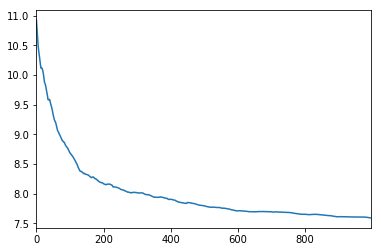

In [237]:
train_state_df = pd.DataFrame(train_state)
train_state_df['loss'].plot()
plt.show()

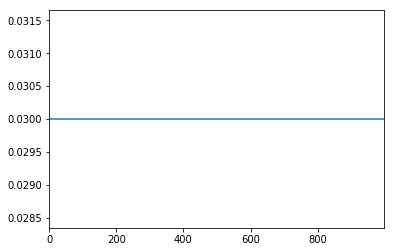

In [238]:
train_state_df['learning_rate'].plot()
plt.show()

In [188]:
metadata = list(sg_batcher.token_to_idx)
W = classifier.embedding.weight.detach().cpu().numpy()
W_prime = classifier.fc1.weight.detach().cpu().numpy()

W_avg = (W + W_prime) / 2
np.savez(args.weights_path, W=W, W_prime=W_prime, W_avg=W_avg)

In [228]:
classifier.embedding.weight_g.shape, classifier.embedding.weight_v.shape

(torch.Size([1, 100]), torch.Size([47134, 100]))

In [229]:
classifier.fc1.weight_g.shape, classifier.fc1.weight_v.shape

(torch.Size([1, 100]), torch.Size([47134, 100]))

In [121]:
# writer.add_embedding(W, metadata=metadata, tag='W')
# writer.add_embedding(W_prime, metadata=metadata, tag='W_prime')
writer.add_embedding(W_avg, metadata=metadata, tag='W_avg')

In [122]:
weights = np.load(args.weights_path)
W = weights['W']
W_prime = weights['W_prime']
W_avg = weights['W_avg']

In [178]:
W.min(), W.max(), W_prime.min(), W_prime.max()

(-3.8279662, 3.4566839, -7.8573947, 6.8002295)

In [34]:
W_norm = W / np.linalg.norm(W, axis=1, keepdims=True)
W_prime_norm = W_avg / np.linalg.norm(W_prime, axis=1, keepdims=True)
W_avg_norm = (W_norm + W_prime_norm) / 2
np.abs(W_norm).max(), np.abs(W_prime_norm).max(), np.abs(W_avg_norm).max()

(0.6583071, 1.2893176, 0.97381234)

In [123]:
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

In [124]:
def plot_embeddings(embs_reduced, token_to_idx, tokens):
    token_embs = embs_reduced[[token_to_idx[token] for token in tokens]]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(token_embs[:, 0], token_embs[:, 1], alpha=0.2)
    
    for i, token in enumerate(tokens):
        ax.annotate(token, (token_embs[i, 0], token_embs[i, 1]))

In [164]:
%%time
pca = PCA(n_components=2)
embs_pca = pca.fit_transform(W_avg)

CPU times: user 356 ms, sys: 0 ns, total: 356 ms
Wall time: 90.3 ms


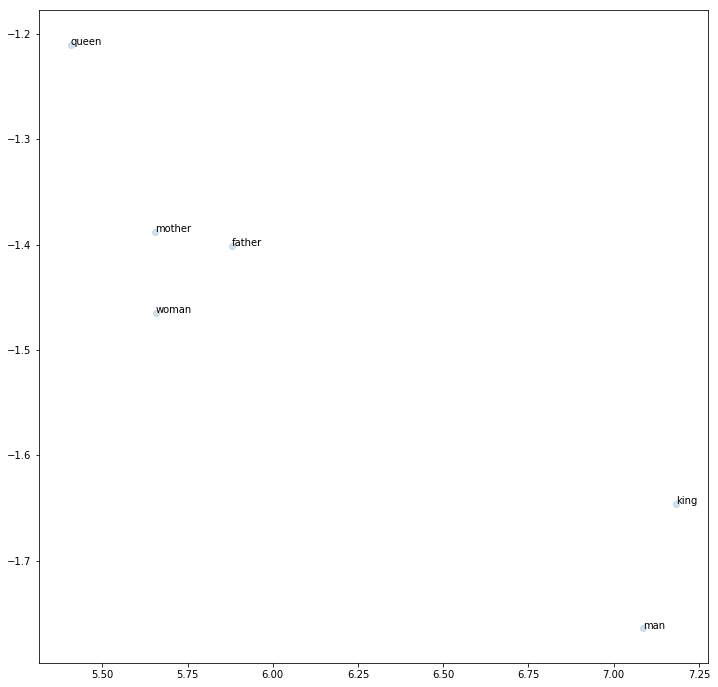

In [165]:
tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_pca, sg_batcher.token_to_idx, tokens)

In [ ]:
%%time
tsne = TSNE(n_components=2, n_iter=1000, n_jobs=-1)
embs_tsne = tsne.fit_transform(W_avg)

In [ ]:
tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_tsne, sg_batcher.token_to_idx, tokens)

In [ ]:
%%time
umap = UMAP(metric='cosine')
embs_umap = umap.fit_transform(W_avg)

In [ ]:
tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_umap, sg_batcher.token_to_idx, tokens)

In [166]:
class EmbeddingsExplorer():
    def __init__(self, token_to_idx, vectors, metric='euclidean'):
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx 
                             in self.token_to_idx.items()}
        self.vectors = vectors
        self.metric = metric
        
        self.index = AnnoyIndex(vectors.shape[1], metric=metric)
        
        print('Building index is started')
        for i in self.token_to_idx.values():
            self.index.add_item(i, self.vectors[i])
        
        self.index.build(50)
        print('Building index is finished')
        
    def get_embedding(self, token):
        return self.vectors[self.token_to_idx[token]]
    
    def get_closest_to_vector(self, vector, n=1):
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.idx_to_token[neighbor] for neighbor in nn_indices]
    
    def compute_analogy(self, token1, token2, token3, n=20):
        vec1 = self.get_embedding(token1)
        vec2 = self.get_embedding(token2)
        vec3 = self.get_embedding(token3)
        vec4 = vec3 + vec2 - vec1
        
        tokens = set([token1, token2, token3])
        closest_tokens = self.get_closest_to_vector(vec4, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token not in tokens]
        
        if len(closest_tokens) == 0:
            print('Could not find nearest neighbors for the computed vector')
            return
        
        for token4 in closest_tokens:
            print(f'{token1}:{token2} :: {token3}:{token4}')

In [167]:
embeddings = EmbeddingsExplorer(sg_batcher.token_to_idx, W_avg, metric='euclidean')
embeddings

Building index is started
Building index is finished


In [246]:
embeddings.compute_analogy('man', 'he', 'woman')

man:he :: woman:she
man:he :: woman:when
man:he :: woman:but
man:he :: woman:was
man:he :: woman:who
man:he :: woman:saw
man:he :: woman:they
man:he :: woman:had
man:he :: woman:however
man:he :: woman:finally
man:he :: woman:never
man:he :: woman:apparently
man:he :: woman:decided
man:he :: woman:initially
man:he :: woman:later
man:he :: woman:after
man:he :: woman:became
man:he :: woman:nevertheless
man:he :: woman:there


In [247]:
embeddings.compute_analogy('fly', 'plane', 'sail')

fly:plane :: sail:vector
fly:plane :: sail:sequence
fly:plane :: sail:blocks
fly:plane :: sail:gravity
fly:plane :: sail:block
fly:plane :: sail:pair
fly:plane :: sail:phase
fly:plane :: sail:generator
fly:plane :: sail:trajectory
fly:plane :: sail:lens
fly:plane :: sail:infinite
fly:plane :: sail:acceleration
fly:plane :: sail:parameter
fly:plane :: sail:surfaces
fly:plane :: sail:measure
fly:plane :: sail:concrete
fly:plane :: sail:bow
fly:plane :: sail:vectors
fly:plane :: sail:linear


In [248]:
embeddings.compute_analogy('kitten', 'cat', 'puppy')

kitten:cat :: puppy:dog
kitten:cat :: puppy:man
kitten:cat :: puppy:girl
kitten:cat :: puppy:word
kitten:cat :: puppy:like
kitten:cat :: puppy:baby
kitten:cat :: puppy:words
kitten:cat :: puppy:short
kitten:cat :: puppy:person
kitten:cat :: puppy:character
kitten:cat :: puppy:boy
kitten:cat :: puppy:meaning
kitten:cat :: puppy:my
kitten:cat :: puppy:black
kitten:cat :: puppy:figure
kitten:cat :: puppy:male
kitten:cat :: puppy:women
kitten:cat :: puppy:female
kitten:cat :: puppy:novel


In [249]:
embeddings.compute_analogy('blue', 'color', 'dog')

blue:color :: dog:etc
blue:color :: dog:similarly
blue:color :: dog:content
blue:color :: dog:mix
blue:color :: dog:includes
blue:color :: dog:label
blue:color :: dog:typically
blue:color :: dog:dogs
blue:color :: dog:pattern
blue:color :: dog:typical
blue:color :: dog:display
blue:color :: dog:sample
blue:color :: dog:picture
blue:color :: dog:frame
blue:color :: dog:drawing
blue:color :: dog:whole
blue:color :: dog:setting
blue:color :: dog:copy
blue:color :: dog:technique


In [172]:
embeddings.compute_analogy('leg', 'legs', 'hand')

leg:legs :: hand:others
leg:legs :: hand:typically
leg:legs :: hand:usually
leg:legs :: hand:etc
leg:legs :: hand:hence
leg:legs :: hand:thus
leg:legs :: hand:while
leg:legs :: hand:often
leg:legs :: hand:animals
leg:legs :: hand:humans
leg:legs :: hand:words
leg:legs :: hand:various
leg:legs :: hand:unlike
leg:legs :: hand:together
leg:legs :: hand:individual
leg:legs :: hand:though
leg:legs :: hand:hands
leg:legs :: hand:therefore
leg:legs :: hand:hold


In [250]:
embeddings.compute_analogy('toe', 'finger', 'foot')

toe:finger :: foot:section
toe:finger :: foot:wall
toe:finger :: foot:bottom
toe:finger :: foot:top
toe:finger :: foot:feet
toe:finger :: foot:points
toe:finger :: foot:track
toe:finger :: foot:face
toe:finger :: foot:leg
toe:finger :: foot:arm
toe:finger :: foot:plus
toe:finger :: foot:notes
toe:finger :: foot:eye
toe:finger :: foot:lines
toe:finger :: foot:stone
toe:finger :: foot:speed
toe:finger :: foot:cap
toe:finger :: foot:walls
toe:finger :: foot:shot


In [251]:
embeddings.compute_analogy('talk', 'communicate', 'read')

talk:communicate :: read:easily
talk:communicate :: read:freely
talk:communicate :: read:proceed
talk:communicate :: read:efficiently
talk:communicate :: read:properly
talk:communicate :: read:transmitted
talk:communicate :: read:copied
talk:communicate :: read:implemented
talk:communicate :: read:execute
talk:communicate :: read:automatically
talk:communicate :: read:treated
talk:communicate :: read:interpreted
talk:communicate :: read:transported
talk:communicate :: read:translate
talk:communicate :: read:transferred
talk:communicate :: read:operate
talk:communicate :: read:recognise
talk:communicate :: read:develop
talk:communicate :: read:appealed
talk:communicate :: read:convert


In [252]:
embeddings.compute_analogy('man', 'king', 'woman')

man:king :: woman:prince
man:king :: woman:son
man:king :: woman:monarch
man:king :: woman:father
man:king :: woman:mayor
man:king :: woman:henry
man:king :: woman:ruler
man:king :: woman:bishop
man:king :: woman:kings
man:king :: woman:lord
man:king :: woman:successor
man:king :: woman:captain
man:king :: woman:alexander
man:king :: woman:president
man:king :: woman:james
man:king :: woman:william
man:king :: woman:arthur
man:king :: woman:charles


In [253]:
embeddings.compute_analogy('man', 'doctor', 'woman')

man:doctor :: woman:genius
man:doctor :: woman:villain
man:doctor :: woman:practitioner
man:doctor :: woman:persona
man:doctor :: woman:wise
man:doctor :: woman:speaker
man:doctor :: woman:bride
man:doctor :: woman:narrator
man:doctor :: woman:nurse
man:doctor :: woman:doom
man:doctor :: woman:bachelor
man:doctor :: woman:protagonist
man:doctor :: woman:sees
man:doctor :: woman:foremost
man:doctor :: woman:assassin
man:doctor :: woman:cf
man:doctor :: woman:speaks
man:doctor :: woman:servant
man:doctor :: woman:choosing


In [177]:
embeddings.compute_analogy('fast', 'fastest', 'small')

fast:fastest :: small:growing
fast:fastest :: small:scale
fast:fastest :: small:size
fast:fastest :: small:huge
fast:fastest :: small:largest
fast:fastest :: small:larger
fast:fastest :: small:overall
fast:fastest :: small:large
fast:fastest :: small:growth
fast:fastest :: small:massive
fast:fastest :: small:substantial
fast:fastest :: small:increasing
fast:fastest :: small:increases
fast:fastest :: small:dominant
fast:fastest :: small:commercial
fast:fastest :: small:vast
fast:fastest :: small:tiny
fast:fastest :: small:amount
fast:fastest :: small:presence


In [58]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=100000)

In [59]:
g = sg_batcher.generate_batches(window_size=5, 
                                batch_size=5)
x_batch, labels_batch = next(g)

x_batch, labels_batch

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 2, 3]))

In [60]:
vocabulary_size = len(sg_batcher.vocab)
embedding_size = 50

vocabulary_size, embedding_size

(22, 50)

In [61]:
clf = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                              embedding_size=embedding_size)

In [102]:
y_pred = clf(x_batch)
# y_pred = F.softmax(y_pred, dim=1)
y_pred

tensor([[ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.078

In [79]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [103]:
y_pred[range(5), labels_batch]

tensor([-0.7678, -0.4254,  0.3084, -0.4254,  0.3084], grad_fn=<IndexBackward>)

In [80]:
-torch.log(y_pred[range(5), labels_batch])

tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NegBackward>)

In [95]:
y_true = torch.zeros((5, vocabulary_size), dtype=torch.long)
y_true[range(5), labels_batch] = 1

In [92]:
y_true.shape, y_pred.shape

(torch.Size([5, 22]), torch.Size([5, 22]))

In [104]:
loss = nn.CrossEntropyLoss(reduce=False)
loss(y_pred, labels_batch)

/opt/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NllLossBackward>)

In [64]:
arr = torch.zeros((5, vocabulary_size))
arr[range(5), labels_batch] = 1
arr.sum(dim=1)

tensor([1., 1., 1., 1., 1.])

In [65]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [70]:
loss = -np.log()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
